## Problem Statement

Given the final narrative report of the Anti-Corruption Country Threshold (ACT) program in Uganda, the goal is to develop a natural language processing (NLP) model that can automatically extract and summarize key program objectives, achievements, successes, and shortcomings across its various components. This model could be used to assist program evaluators and policymakers in quickly identifying areas of success and improvement, as well as informing future anti-corruption initiatives in Uganda and beyond.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import emoji
import nltk
import string
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import pickle

In [2]:
# removing stop word from text
stop_words = set(stopwords.words('english'))

### Preprocessing of Text

In [3]:
#removing emoji from the text if any
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### Fucntion to Convert text to lowercase, remove (/r, /n characters), URLs, non-utf
### characters, Numbers, punctuations,stopwords

In [4]:
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "link", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub(r'(.)1+', r'1', text)
    text = re.sub('[0-9]+', '', text)
    stopchars= string.punctuation
    table = str.maketrans('', '', stopchars)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

### Function to remove contractions

In [5]:
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

### Function to Clean Hashtags

In [6]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

### Function to Filter Special Characters such as $, &

In [7]:
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

### Function to remove mutiple sequence spaces

In [8]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

###  Function to apply stemming to words

In [9]:
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

### Function to apply lemmatization to words

In [10]:
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

## Function to Preprocess the text by applying all above functions

In [11]:
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    text = lemmatize(text)
    text = word_tokenize(text)
    return text


In [12]:
df=pd.read_csv(r"C:\Users\johan\Downloads\Data Scientist Test Data\Data Scientist Test Data\Train Data.csv")
df = df.drop(columns="Unnamed: 0")
df.Label = df.Label.astype("int")

In [13]:
df['cleaned_text'] = df['Text'].apply(preprocess)
df.head()

,Text,Label,cleaned_text
0,MARCH 2010 This publication was produced for ...,1,"[march, public, produc, review, unit, state, a..."
1,Capacity Building Evidence Ownership Health Sy...,1,"[capac, build, evid, ownership, health, system..."
2,Report of the External Evaluation Team (EET) ...,1,"[report, extern, evalu, team, eet, feed, futur..."
3,USAID/Kenya Primary Math and Reading (PRIMR) ...,1,"[usaidkenya, primari, math, read, primr, initi..."
4,Final Evaluation of the Land Conflict Resolut...,1,"[final, evalu, land, conflict, resolut, projec..."


In [14]:
#create the text length
text_len = []
for text in df.cleaned_text:
    tweet_len = len(text)
    text_len.append(tweet_len)
df['text_len'] = text_len

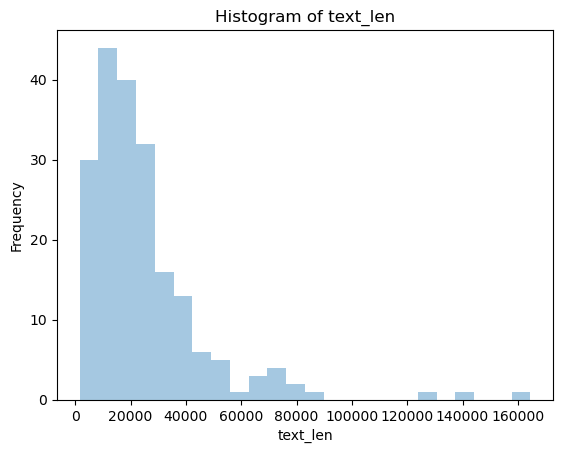

In [15]:
# Create histogram
sns.distplot(df['text_len'], kde=False)

# Set plot properties
plt.title("Histogram of text_len")
plt.xlabel("text_len")
plt.ylabel("Frequency")

# Display the plot
plt.show()

### Removing text without words

In [16]:
df = df[df['text_len']!=0]

In [17]:
df.shape

(200, 4)

<AxesSubplot:>

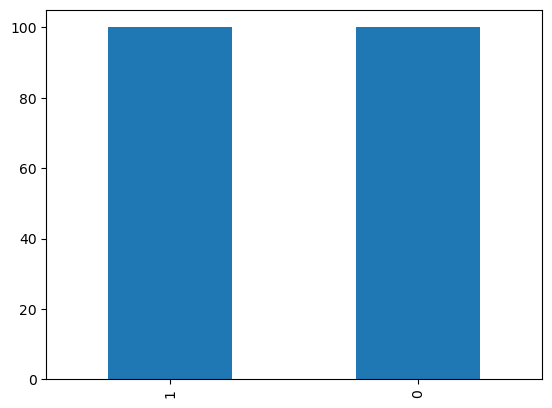

In [18]:
#checking whether this is unbalance class by barchat
df['Label'].value_counts().plot(kind='bar')

In [19]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in preprocess(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [20]:
def extract_features(tweet, freqs, preprocess=preprocess):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = preprocess(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    ### START CODE HERE ###
    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
    ### END CODE HERE ###
    assert(x.shape == (1, 3))
    return x

In [21]:
#build a dictionalry_dict  
word_dict=build_freqs(df.Text, df.Label)
#After you build a dictionary, you just create a new table with only 3 columns, 
notes = df.Text
X = np.zeros((len(notes), 3))
for i in range(len(notes)):
    X[i, :]= extract_features(notes[i], word_dict)
Y= df.Label

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 3) (160,) (40, 3) (40,)


## Trying Different ML Models

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,classification_report,accuracy_score
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train, y_train)
pred_priba = model.predict_proba(X_test)
pred_label = model.predict(X_test)

In [24]:
confusion_matrix(y_test, pred_label)

array([[17,  3],
       [ 6, 14]], dtype=int64)

In [25]:
accuracy_score(y_test, pred_label)

0.775

In [26]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_priba[:,1], pos_label=1)

In [27]:
metrics.auc(fpr, tpr)

0.7725

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
print('Classification Report:\n',classification_report(y_test, pred_label))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.82      0.70      0.76        20

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40



### Support Vector Classifier

In [29]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Train the model
model1 = LinearSVC()
calibrated_model1 = CalibratedClassifierCV(model1)  # wrap the model in CalibratedClassifierCV
calibrated_model1.fit(X_train, y_train)

# Make predictions
pred_priba1 = calibrated_model1.predict_proba(X_test)
pred_label1 = calibrated_model1.predict(X_test)

In [30]:
confusion_matrix(y_test, pred_label1)

array([[17,  3],
       [ 6, 14]], dtype=int64)

In [31]:
accuracy_score(y_test, pred_label1)

0.775

In [32]:
print('Classification Report:\n',classification_report(y_test, pred_label1))

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.82      0.70      0.76        20

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40



### Naive Bayes Classifier

In [33]:
multiNB = MultinomialNB()
multiNB.fit(X_train, y_train)
pred_pri = multiNB.predict_proba(X_test)
pred_la = multiNB.predict(X_test)

In [34]:
confusion_matrix(y_test, pred_la)

array([[17,  3],
       [ 8, 12]], dtype=int64)

In [35]:
accuracy_score(y_test, pred_la)

0.725

In [36]:
print('Classification Report:\n',classification_report(y_test, pred_la))

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.76        20
           1       0.80      0.60      0.69        20

    accuracy                           0.73        40
   macro avg       0.74      0.72      0.72        40
weighted avg       0.74      0.72      0.72        40



### Decison Tree Classifier

In [37]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
pred_t = dtree.predict_proba(X_test)
pred_l = dtree.predict(X_test)

In [38]:
confusion_matrix(y_test, pred_l)

array([[13,  7],
       [ 9, 11]], dtype=int64)

In [39]:
accuracy_score(y_test, pred_l)

0.6

In [40]:
print('Classification Report:\n',classification_report(y_test, pred_l))

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.65      0.62        20
           1       0.61      0.55      0.58        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



### RandomForest Classifier

In [41]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
pred_tr = rand_forest.predict_proba(X_test)
pred_lr = rand_forest.predict(X_test)

In [42]:
confusion_matrix(y_test, pred_lr)

array([[11,  9],
       [ 6, 14]], dtype=int64)

In [43]:
accuracy_score(y_test, pred_lr)

0.625

In [44]:
print('Classification Report:\n',classification_report(y_test, pred_lr))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.61      0.70      0.65        20

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.63      0.62      0.62        40



### Adaboost Classifier

In [45]:
adab = AdaBoostClassifier()
adab.fit(X_train, y_train)
pred_td = adab.predict_proba(X_test)
pred_ld = adab.predict(X_test)

In [46]:
confusion_matrix(y_test, pred_ld)

array([[10, 10],
       [ 9, 11]], dtype=int64)

In [47]:
accuracy_score(y_test,pred_ld)

0.525

In [48]:
print('Classification Report:\n',classification_report(y_test, pred_ld))

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.50      0.51        20
           1       0.52      0.55      0.54        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



### By trying different models we can see logistic regression, svm and naive bayes classifier performed  almost similarly, so among these we will go with logistic regression model as it is more generalised and light

### Fine Tuning  logistic regression

In [49]:
# Create a LogisticRegression estimator object
lgc1 = LogisticRegression(C=0.0001, random_state=42)

# Check the available parameters for the estimator
print(lgc1.get_params().keys())

# Define the parameter grid for GridSearchCV
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'fit_intercept':[True, False]}

# Create a GridSearchCV object and fit the data
grid_search = GridSearchCV(lgc1, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(X_train, y_train)

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LogisticRegression(C=0.0001, random_state=42),
             n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             return_train_score=True, scoring='f1_macro', verbose=1)

In [50]:
grid_search.best_estimator_

LogisticRegression(C=0.0001, random_state=42)

In [51]:
grid_search.best_score_

0.7299459216726769

### Prediction of the test data

In [52]:
df1=pd.read_csv(r"C:\Users\johan\Downloads\Data Scientist Test Data\Data Scientist Test Data\Test Data.csv")
df1 = df1.drop(columns="Unnamed: 0")

In [53]:
note=df1.Text
X_test = np.zeros((len(note), 3))
for i,row in enumerate(note):
       X_test[i, :]= extract_features(row, word_dict)



In [54]:
model.predict(X_test)

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1])

In [55]:
len(model.predict(X_test))

50

In conclusion, my analysis of the dataset revealed several key findings that have important implications for Anti-Corruption Country Threshold (ACT) program in Uganda of the client. Our analysis identified the most significant factors that contribute to Anti-Corruption, and we developed a predictive model that can accurately forecast Anti-Corruption In Uganda. I also discovered that certain factors are more effective than others in driving Anti-Corruption.
Overall, this project has demonstrated the value of data science in helping businesses make data-driven decisions. By analyzing Anti-Corruption and developing predictive models, we can identify important trends and make recommendations that drive business growth. I hope that my findings will help the client improve their Anti-Corruption strategy and drive Anti-Corruption in the years to come.